# Examples: Simple

In [1]:
import numpy as np
import sys
sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.agent_types.basics import map_e
from IoTPy.helper_functions.recent_values import recent_values

In [2]:
#--------------------------------------------------------
# Agent that evaluates a polynomial on values in a stream
#--------------------------------------------------------
@map_e
def evaluate_polynomial(number, polynomial):
    return np.polyval(polynomial, number)


In [3]:
def test_evaluate_polynomial():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    evaluate_polynomial(x, y, polynomial=[1, 0, 1])

    # Put data in input streams
    x.extend(np.array([1.0, 4.0, 3.0, 0.0]))

    # Execute a step
    print ('running')
    run()

    # Look at values of output streams
    assert np.array_equal(
        recent_values(y), np.array([2.0, 17.0, 10.0, 1.0]))
    print (recent_values(y))
    
test_evaluate_polynomial()

running
[ 2. 17. 10.  1.]


In [4]:
from IoTPy.agent_types.basics import merge_e
#----------------------------------------------------
# Agent that computes the magnitude of a vector
#----------------------------------------------------
@merge_e 
def magnitude_of_vector(coordinates):
    return np.linalg.norm(coordinates)

In [5]:
def test_magnitude_of_vector():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')
    z = StreamArray('z')
    magnitude_stream = StreamArray('magnitudes')

    # Create agent
    magnitude_of_vector([x,y,z], magnitude_stream)

    # Put data in streams
    x.extend(np.array([1.0, 4.0, 3.0]))
    y.extend(np.array([2.0, 4.0, 0.0]))
    z.extend(np.array([2.0, 2.0, 4.0]))

    # Execute a step
    run()

    # Look at values of output streams
    assert np.array_equal(recent_values(magnitude_stream),
                           np.array([3.0, 6.0, 5.0]))
    print (recent_values(magnitude_stream))
test_magnitude_of_vector()

[3. 6. 5.]


In [6]:
from IoTPy.agent_types.op import map_element
def exponential_smoothing(in_stream, out_stream, smoothing_factor):
    """
    With input stream x and output stream y:
    y[0] = x[0]
    y[n] = a*x[n] + (1-a)*y[n-1] for n > 0.
    where a is smoothing_factor

    """
    def f(in_stream_element, state, a):
        if state is 'empty':
            next_state = in_stream_element
        else:
            next_state = (1.0-a)*state+ a*in_stream_element
            # return out_stream_element, next_state
            # Note: out_stream_element = next_state
            # So, return next_state, next_state
        return next_state, next_state
    # Create a map_element agent
    map_element(f, in_stream, out_stream,
                state='empty', a=smoothing_factor)

In [7]:
def test_exponential_smoothing():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    exponential_smoothing(in_stream=x, out_stream=y, smoothing_factor=0.25)

    # Put data in streams
    x.extend([1.0]+[0.0]*5)

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))

    x = StreamArray('x')
    y = StreamArray('y')

    exponential_smoothing(in_stream=x, out_stream=y, smoothing_factor=0.25)

    x.extend(np.arange(5.0))

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))
test_exponential_smoothing()

[1.         0.75       0.5625     0.421875   0.31640625 0.23730469]
[0.         0.25       0.6875     1.265625   1.94921875]


In [8]:
def exponential_smooth_and_add(in_stream, out_stream, smoothing_factor):
    """
    With input stream x and output stream y:
    y[n] = x[n] + a*x[n-1] + .. + a^m * x[n-m] + ....
    where a is smoothing_factor

    """
    def f(in_stream_element, state, a):
        next_state = state*a + in_stream_element
        # return out_stream_element, next_state
        # Note: out_stream_element = next_state
        return next_state, next_state
    # Create a map_element agent
    map_element(f, in_stream, out_stream,
                state=0.0, a=smoothing_factor)

In [9]:
def test_exponential_smooth_and_add():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    exponential_smooth_and_add(in_stream=x, out_stream=y, smoothing_factor=0.25)

    # Put data in streams
    x.extend([1.0]+[0.0]*5)

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))

    x = StreamArray('x')
    y = StreamArray('y')

    exponential_smooth_and_add(in_stream=x, out_stream=y, smoothing_factor=0.25)

    x.extend(np.arange(5.0))

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))
test_exponential_smooth_and_add()

[1.000000e+00 2.500000e-01 6.250000e-02 1.562500e-02 3.906250e-03
 9.765625e-04]
[0.       1.       2.25     3.5625   4.890625]


In [10]:
def add_value_to_stream_array(in_stream, out_stream, window_size, addend):
    def f(an_array):
        return _multivalue(an_array + addend)
    map_window(f,in_stream_array, out_stream_array,
        window_size=window_size,step_size=window_size)

In [11]:
from IoTPy.agent_types.op import map_window
def window_dot_product(in_stream, out_stream, multiplicand_vector, step_size=1):
    def f(window, multiplicand_vector): return np.dot(window, multiplicand_vector)
    map_window(f, in_stream, out_stream,
               len(multiplicand_vector), step_size, multiplicand_vector=multiplicand_vector)

In [12]:
def test_window_dot_product():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    window_dot_product(x, y, multiplicand_vector=[2, 100])

    # Put data in streams
    x.extend(np.arange(8.0))

    # Execute a step
    run()

    # Look at values of output streams
    assert np.array_equal(recent_values(y), 
                          np.array([100., 202., 304., 406., 508., 610., 712.]))
    print (recent_values(y))

test_window_dot_product()

[100. 202. 304. 406. 508. 610. 712.]


In [13]:
from IoTPy.agent_types.basics import map_w
from IoTPy.agent_types.op import map_window
#----------------------------------------------------
# Agent that subtracts the mean in a stream
#----------------------------------------------------
@map_w
def subtract_mean(window):
    return window[0] - np.mean(window)

In [14]:
import matplotlib.pyplot as plt
NUM_CYCLES= 4
NUM_POINTS_PER_CYCLE=18

x = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
y = np.sin(x) + 1.0

plt.plot(x, y)
plt.show()

<Figure size 640x480 with 1 Axes>

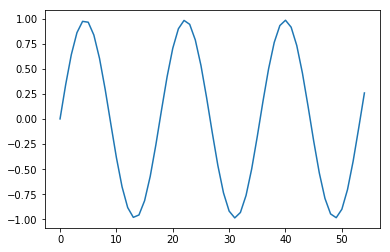

In [15]:
y_stream = StreamArray('y_stream')
z = StreamArray('z')
subtract_mean(in_stream=y_stream, out_stream=z, window_size=18, step_size=1)
y_stream.extend(y)
run()
plt.plot(recent_values(z))
plt.show()

In [16]:
from IoTPy.core.stream import _multivalue
#----------------------------------------------------
# Agent that subtracts the mean in a stream in blocks
#----------------------------------------------------
@map_w
def subtract_mean_block(window, block_size):
    a = window - np.mean(window)
    return _multivalue(a[:block_size])

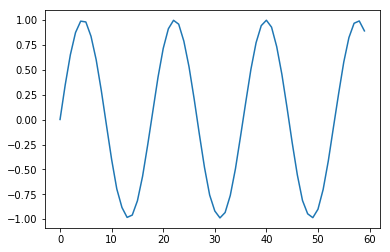

In [17]:
def test_subtract_mean_block():
    NUM_CYCLES= 4
    NUM_POINTS_PER_CYCLE=18

    x = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
    y = np.sin(x) + 1.0
    # Declare streams
    y_stream = StreamArray('y_stream')
    z = StreamArray('z')
    subtract_mean_block(in_stream=y_stream, out_stream=z, window_size=18, step_size=6,
                       block_size=6)
    y_stream.extend(y)
    run()

    plt.plot(recent_values(z))
    plt.show()
test_subtract_mean_block()

In [18]:
def sum_window_incremental(in_stream, out_stream, window_size):
    @map_w
    def sum_window_incremental_func(window, state):
        starting, total = state
        if starting:
            starting = False
            total = sum(window)
        else:
            total += window[-1]
        next_state = starting, total-window[0]
        return total, next_state

    # Create agent
    sum_window_incremental_func(
        in_stream, out_stream, window_size, step_size=1, state=(True, 0))

In [19]:
def test_sum_window_incremental():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dtype='int')

    # Create agent
    sum_window_incremental(in_stream=x, out_stream=y, window_size=5)

    # Put data in streams
    x.extend(list(range(10)))

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_sum_window_incremental()

[10 15 20 25 30 35]


In [20]:
from IoTPy.core.stream import _no_value
@map_e
def time_of_crossing_threshold(value, state, threshold):
    return (state if abs(value) > threshold else _no_value, state+1)

In [21]:
def test_time_of_crossing_threshold():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dtype='int')

    # Create agent
    time_of_crossing_threshold(in_stream=x, out_stream=y, state=0, threshold=2.5)

    # Put data in streams
    x.extend([1, 2, 5, 0, 9, 10, 11, 10, 9, 5, 1, 0, 2])

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_time_of_crossing_threshold()

[2 4 5 6 7 8 9]


In [22]:
@map_e
def quenched_time_of_crossing_threshold(
        value, state, threshold, quench_duration):
    current_time, last_quench_time = state
    if ((current_time <= last_quench_time + quench_duration) or
        (abs(value) <= threshold)):
        signal = _no_value
    else:
        signal = (current_time, value)
        last_quench_time = current_time
    next_state = (current_time+1, last_quench_time)
    return signal, next_state

In [23]:
def test_quenched_time_of_crossing_threshold():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dimension=(2,), dtype='int')

    # Create agent
    quenched_time_of_crossing_threshold(
        in_stream=x, out_stream=y, state=(0,0), threshold=2.5, quench_duration=2)

    # Put data in streams
    x.extend([1, 2, 5, 0, 9, 10, 11, 10, 9, 5, 1, 0, 2, 10, 10, 10, 10, 20, 1])

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_quenched_time_of_crossing_threshold()
    

[[ 4  9]
 [ 7 10]
 [13 10]
 [16 10]]
